In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:


def select_for_gz_mobile(df, num_galaxies=1000):
    assert len(df) > num_galaxies
    df_sorted = df.sort_values('rare-features_ring_fraction', ascending=False)
    return df_sorted[:num_galaxies], df_sorted[num_galaxies:]


def get_fake_mobile_votes(gz_ring_vote_fractions):
    return scipy.stats.binom(n=10, p=gz_ring_vote_fractions).rvs(len(gz_ring_vote_fractions))


In [3]:
frac_cols = ['smooth-or-featured_smooth_fraction',
 'smooth-or-featured_featured-or-disk_fraction',
 'smooth-or-featured_artifact_fraction',
 'disk-edge-on_yes_fraction',
 'disk-edge-on_no_fraction',
 'has-spiral-arms_yes_fraction',
 'has-spiral-arms_no_fraction',
 'bar_strong_fraction',
 'bar_weak_fraction',
 'bar_no_fraction',
 'bulge-size_dominant_fraction',
 'bulge-size_large_fraction',
 'bulge-size_moderate_fraction',
 'bulge-size_small_fraction',
 'bulge-size_none_fraction',
 'how-rounded_round_fraction',
 'how-rounded_in-between_fraction',
 'how-rounded_cigar-shaped_fraction',
 'edge-on-bulge_boxy_fraction',
 'edge-on-bulge_none_fraction',
 'edge-on-bulge_rounded_fraction',
 'spiral-winding_tight_fraction',
 'spiral-winding_medium_fraction',
 'spiral-winding_loose_fraction',
 'spiral-arm-count_1_fraction',
 'spiral-arm-count_2_fraction',
 'spiral-arm-count_3_fraction',
 'spiral-arm-count_4_fraction',
 'spiral-arm-count_more-than-4_fraction',
 'spiral-arm-count_cant-tell_fraction',
 'merging_none_fraction',
 'merging_minor-disturbance_fraction',
 'merging_major-disturbance_fraction',
 'merging_merger_fraction']

In [4]:
decals_df = pd.read_parquet(
    '/Users/walml/repos/zoobot_private/gz_decals_auto_posteriors.parquet',
    columns=frac_cols + ['iauname'])

In [5]:
# use vote fractions for now? but selected to fairly high fractions

rare_df = pd.read_parquet('/Users/walml/repos/zoobot/data/rare_features_dr5_with_ml_morph.parquet')
del rare_df['smooth-or-featured_featured-or-disk_fraction']
del rare_df['disk-edge-on_no_fraction']
del rare_df['has-spiral-arms_no_fraction']
rare_df['is_ring'] = rare_df['rare-features_ring_fraction'] > 0.25   # TODO fraction. What the experts say, close enough for now


In [6]:
rare_df.columns.values

array(['iauname', 'rare-features_value', 'rare-features_total',
       'rare-features_nothing', 'rare-features_ring',
       'rare-features_irregular', 'rare-features_something-else',
       'rare-features_overlapping', 'rare-features_dust-lane',
       'rare-features_lens-or-arc', 'rare-features_nothing_fraction',
       'rare-features_ring_fraction', 'rare-features_irregular_fraction',
       'rare-features_something-else_fraction',
       'rare-features_overlapping_fraction',
       'rare-features_dust-lane_fraction',
       'rare-features_lens-or-arc_fraction', 'png_loc', 'tag_count',
       'local_png_loc', 'ring', 'is_ring'], dtype=object)

In [7]:
vote_df = pd.merge(decals_df, rare_df, on='iauname', how='inner')

In [8]:
vote_df.columns.values

array(['smooth-or-featured_smooth_fraction',
       'smooth-or-featured_featured-or-disk_fraction',
       'smooth-or-featured_artifact_fraction',
       'disk-edge-on_yes_fraction', 'disk-edge-on_no_fraction',
       'has-spiral-arms_yes_fraction', 'has-spiral-arms_no_fraction',
       'bar_strong_fraction', 'bar_weak_fraction', 'bar_no_fraction',
       'bulge-size_dominant_fraction', 'bulge-size_large_fraction',
       'bulge-size_moderate_fraction', 'bulge-size_small_fraction',
       'bulge-size_none_fraction', 'how-rounded_round_fraction',
       'how-rounded_in-between_fraction',
       'how-rounded_cigar-shaped_fraction', 'edge-on-bulge_boxy_fraction',
       'edge-on-bulge_none_fraction', 'edge-on-bulge_rounded_fraction',
       'spiral-winding_tight_fraction', 'spiral-winding_medium_fraction',
       'spiral-winding_loose_fraction', 'spiral-arm-count_1_fraction',
       'spiral-arm-count_2_fraction', 'spiral-arm-count_3_fraction',
       'spiral-arm-count_4_fraction',
       

In [9]:
mobile_df, not_mobile_df = select_for_gz_mobile(vote_df, num_galaxies=5000)


In [10]:

mobile_df['ring_votes'] = get_fake_mobile_votes(mobile_df['rare-features_ring_fraction'].values)
not_mobile_df['ring_votes'] = get_fake_mobile_votes(np.ones(len(not_mobile_df))*0.03)  # assume base rate - TODO could be better

mobile_train_df, mobile_val_df = train_test_split(mobile_df, test_size=0.2)
not_mobile_train_df, not_mobile_val_df = train_test_split(not_mobile_df, test_size=0.2)

train_df = pd.concat([mobile_train_df, not_mobile_train_df[:len(mobile_train_df)]])  # equal size
val_df = pd.concat([mobile_val_df, not_mobile_val_df[:len(mobile_train_df)]])

train_df = train_df.sample(len(train_df))
val_df = val_df.sample(len(val_df))

In [11]:
# frac_cols = [col for col in decals_df.columns.values if col.endswith('_fraction')]
# frac_cols
batch_size = 128

In [12]:

mobile_train_dataset = tf.data.Dataset.from_tensor_slices((train_df[frac_cols], train_df['ring_votes'].astype(np.float32))).batch(batch_size)
mobile_val_dataset = tf.data.Dataset.from_tensor_slices((val_df[frac_cols], val_df['ring_votes'].astype(np.float32))).batch(batch_size)

2021-08-12 11:19:35.337204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
for batch in mobile_train_dataset.take(1):
    print(batch)

(<tf.Tensor: shape=(128, 34), dtype=float64, numpy=
array([[0.06139668, 0.89803319, 0.04057013, ..., 0.19695421, 0.04601006,
        0.01199553],
       [0.75343465, 0.17363223, 0.07293312, ..., 0.09672001, 0.02330925,
        0.01372639],
       [0.67068268, 0.27760468, 0.05171264, ..., 0.21243904, 0.02813141,
        0.01386826],
       ...,
       [0.29556386, 0.61244115, 0.09199499, ..., 0.25026891, 0.07821   ,
        0.02548909],
       [0.72630126, 0.20996549, 0.06373325, ..., 0.29385262, 0.06728312,
        0.07135182],
       [0.28608166, 0.62457949, 0.08933885, ..., 0.22583223, 0.20784676,
        0.02799618]])>, <tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.,  0.,  0.,  0.,  8.,  8.,  0.,  6.,  5.,  6.,  0.,  0.,  1.,
        0.,  6.,  0., 10., 10.,  4.,  9.,  6.,  0.,  4.,  8.,  1.,  0.,
        5.,  5.,  5.,  0.,  0., 10.,  1.,  0.,  7.,  7.,  0.,  6., 10.,
        6.,  0.,  7.,  7.,  0.,  0.,  1., 10.,  0.,  0.,  0.,  0.,  0.,
        7.,  0.,  6.,  6., 10.,  

In [14]:
# def binomial_loss(y_true, y_pred):  # y_true should be the counts, y_pred should be the predicted probabilities
#     return -tfp.distributions.Binomial(total_count=10, probs=y_pred).log_prob(y_true)  # important minus sign

def dirichlet_multinomial_loss(y_true, y_pred):
    # expects y_pred to be [alpha, beta], each from e.g. 1 to 101 if using Lambda layer
    votes = tf.concat([y_true, 10-y_true], axis=1)  # need to mirror the "no" vote as could in principle be many answers
    return -tfp.distributions.DirichletMultinomial(total_count=10, concentration=y_pred).log_prob(votes)

In [15]:
# batch[1]

In [16]:
# binomial_loss(batch[1], tf.constant(0.8))

In [17]:

classifier = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(frac_cols))),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
#     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)  # for binomial loss
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),  # for Dirichlet-Multinomial loss,
    tf.keras.layers.Lambda(lambda x: (x * 100) + 1, output_shape=(2))
])

classifier.compile(
#     loss=binomial_loss,
    loss = dirichlet_multinomial_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# train to estimate p(ring|votes,voted)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10)

classifier.fit(mobile_train_dataset, validation_data=mobile_val_dataset, epochs=40, callbacks=[early_stopping_callback], verbose=2)

Epoch 1/40


2021-08-12 11:19:35.934128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


63/63 - 1s - loss: 3.5742 - val_loss: 2.9616
Epoch 2/40
63/63 - 0s - loss: 2.8208 - val_loss: 2.0782
Epoch 3/40
63/63 - 0s - loss: 2.1349 - val_loss: 1.6441
Epoch 4/40
63/63 - 0s - loss: 1.9630 - val_loss: 1.5736
Epoch 5/40
63/63 - 0s - loss: 1.9311 - val_loss: 1.5479
Epoch 6/40
63/63 - 0s - loss: 1.9153 - val_loss: 1.5288
Epoch 7/40
63/63 - 0s - loss: 1.9050 - val_loss: 1.5167
Epoch 8/40
63/63 - 0s - loss: 1.8973 - val_loss: 1.5070
Epoch 9/40
63/63 - 0s - loss: 1.8915 - val_loss: 1.4984
Epoch 10/40
63/63 - 0s - loss: 1.8870 - val_loss: 1.4932
Epoch 11/40
63/63 - 0s - loss: 1.8836 - val_loss: 1.4879
Epoch 12/40
63/63 - 0s - loss: 1.8807 - val_loss: 1.4821
Epoch 13/40
63/63 - 0s - loss: 1.8781 - val_loss: 1.4782
Epoch 14/40
63/63 - 0s - loss: 1.8759 - val_loss: 1.4761
Epoch 15/40
63/63 - 0s - loss: 1.8740 - val_loss: 1.4721
Epoch 16/40
63/63 - 0s - loss: 1.8722 - val_loss: 1.4700
Epoch 17/40
63/63 - 0s - loss: 1.8708 - val_loss: 1.4688
Epoch 18/40
63/63 - 0s - loss: 1.8695 - val_loss: 1

In [18]:
print(classifier.evaluate(mobile_val_dataset))

40/40 [==============================] - 0s 1ms/step - loss: 1.4498
1.4498131275177002


In [19]:
batch[1]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.,  0.,  0.,  0.,  8.,  8.,  0.,  6.,  5.,  6.,  0.,  0.,  1.,
        0.,  6.,  0., 10., 10.,  4.,  9.,  6.,  0.,  4.,  8.,  1.,  0.,
        5.,  5.,  5.,  0.,  0., 10.,  1.,  0.,  7.,  7.,  0.,  6., 10.,
        6.,  0.,  7.,  7.,  0.,  0.,  1., 10.,  0.,  0.,  0.,  0.,  0.,
        7.,  0.,  6.,  6., 10.,  0.,  2.,  5.,  0.,  1.,  1.,  0.,  7.,
        5.,  0.,  9.,  5.,  7.,  0.,  7.,  0.,  0.,  0.,  4.,  6.,  7.,
       10.,  0.,  0.,  4.,  3.,  2.,  6.,  5.,  0.,  1.,  9.,  0.,  3.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  6.,  9.,  0.,
        5.,  0.,  0.,  5.,  7., 10.,  0.,  0.,  9.,  0.,  6.,  2.,  7.,
        1.,  0.,  4.,  7.,  9.,  4.,  9., 10.,  3.,  5.,  0.],
      dtype=float32)>

In [20]:
example_preds = classifier.predict(batch[0][:batch_size])[:10]
example_preds

array([[ 1.0658929,  3.5772662],
       [ 1.3635943,  3.0101876],
       [ 1.0937492,  2.98451  ],
       [ 1.0018427, 13.103471 ],
       [ 1.1130611,  1.8840322],
       [ 1.015378 ,  3.0323098],
       [ 1.0322491, 10.618849 ],
       [ 2.1261315,  1.5645335],
       [ 1.83884  ,  1.652039 ],
       [ 2.1430383,  2.692572 ]], dtype=float32)

In [21]:
def viz_multinomial(concentrations):
    x_votes = np.arange(10)
    votes = np.stack([x_votes, 10-x_votes], axis=1)
    for n, concentration in enumerate(concentrations):
        plt.plot(x_votes, tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes))
    #     plt.axvline(batch[1][n])

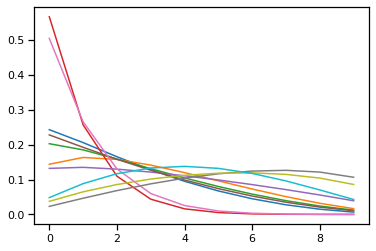

In [22]:
viz_multinomial(example_preds)

In [23]:
# and now calibrate to estimate p(ring)

In [24]:
# unlabelled_df = vote_df.sample(10000)  # to be calibrated
all_preds = classifier.predict(vote_df[frac_cols])

In [25]:

random_expert_labels = vote_df.sample(1000)  # for estimating ring rate in random sample
expert_labelled_rings = random_expert_labels.query('is_ring')
random_expert_ring_preds = classifier.predict(expert_labelled_rings[frac_cols])


expert_labelled_not_rings = random_expert_labels[~random_expert_labels['is_ring']]
random_expert_not_ring_preds = classifier.predict(expert_labelled_not_rings[frac_cols])


In [26]:
random_expert_ring_preds.mean(axis=1)

array([ 2.8739433,  1.6351471,  2.871811 ,  3.307217 ,  2.2466445,
        1.3427432,  2.3423264,  1.5622075,  1.7421166,  3.7375503,
        1.9978681,  2.628828 ,  1.9478211,  3.8415697,  2.3179839,
        2.6566322,  1.7541761,  1.4382863,  1.5091608,  1.7504508,
        6.8351336,  1.5562067,  3.4690032,  1.8605733,  2.9019828,
        1.9563357,  2.0801017,  1.4318609,  2.01081  ,  1.8436024,
        1.687468 ,  2.4204488, 10.8400545,  2.0601833,  1.5497143,
        2.1135297,  1.9459229,  1.8103714,  1.9429247,  1.6564349,
        4.019549 ,  1.6376117,  1.6541014,  1.8153274,  1.6372406,
        1.8548975,  1.9919927,  8.252371 ,  1.4657865,  1.9195075,
        3.7796223,  2.6980484,  2.2327237,  2.290691 ,  2.5881271,
        2.8631556,  1.6924226,  1.804074 ,  1.383313 ,  1.3777728,
        2.410009 ,  2.0297894,  1.7704154,  1.8209898,  2.464334 ],
      dtype=float32)

In [27]:
def concentrations_to_mode_prob(concentrations):
    return (concentrations[:, 0]-1)/(concentrations[:, 1]+concentrations[:, 0]-2)

In [28]:
def concentrations_to_mean_prob(concentrations):
#     https://en.wikipedia.org/wiki/Beta_distribution
    return 1/(1+(concentrations[:, 1]/concentrations[:, 0]))

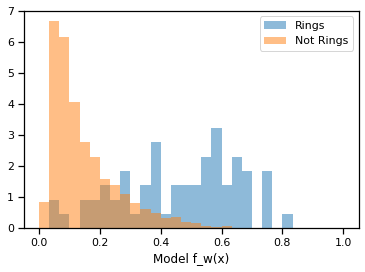

In [29]:
# _, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# # plt.hist(random_preds, density=True, alpha=.5, label='All', bins=viz_bins)
# plt.hist(random_expert_ring_preds, density=True, alpha=.5, label='Rings', bins=viz_bins)
# plt.hist(random_expert_not_ring_preds, density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# # should be same as they are all random
# plt.xlabel('Model f_w(x)')
# plt.legend()

_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(random_preds, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(concentrations_to_mean_prob(random_expert_ring_preds), density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(concentrations_to_mean_prob(random_expert_not_ring_preds), density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('Model f_w(x)')
plt.legend()

In [30]:
def get_percentile_bins(x, num_bins=10):
    percentiles_to_check = [n * (100/num_bins) for n in range(0, num_bins+1)]

    # 11 percentiles, forming 10 bins
    percentiles = np.percentile(x, percentiles_to_check)  # percentiles of all predictions
    percentiles[-1] = percentiles[-1] + 1e-8  # deals with the awkwards == max case
    
    bins = np.array([(low_p, high_p) for (low_p, high_p) in zip(percentiles[:-1], percentiles[1:])])
    bin_centers = np.array([low_p + ((high_p - low_p)/2) for (low_p, high_p) in zip(percentiles[:-1], percentiles[1:])])
    return percentiles, bins, bin_centers

In [31]:
def get_percentile_histogram(x, percentiles, normalize=True):
    # digitize gives index such that x is between bins[i-1] < x < bins[i]
    # values outside the range snap to the closest bin (i.e. 0 or len(bins))
    bin_of_each_x = np.digitize(x, percentiles)
    x_per_bin_counter = Counter(bin_of_each_x)
#     rings_per_bin_counter  # will have indices from 1 to 11 (as x == min bin gives 1, not 0)
    assert x_per_bin_counter[len(percentiles)+1] == 0
    
    num_bins = len(percentiles)-1
    x_per_bin = np.zeros(num_bins)  # 10 
    for bin_index in range(num_bins): # 0 to 10
        x_per_bin[bin_index] = x_per_bin_counter[bin_index+1]  # indexed via 1 to 11
        
    assert x_per_bin.sum() == len(x)

    if normalize:
        return x_per_bin / len(x)
    else:
        return x_per_bin  # counts of values from percentile[i] to percentile[i+1]. Will be one less then len(percentiles)

In [32]:
# or, can draw a (continuous) value from DM and use that as the score

In [33]:
def preds_to_sampled_vote(concentrations, num_samples=100):
#     WHY WHY WHY is concentration0 beta and concentration1 alpha...
    beta = tfp.distributions.Beta(concentration1=concentrations[:,0], concentration0=concentrations[:, 1])
    return beta.sample(100).numpy().flatten()

In [34]:
def preds_to_mean_prob(concentrations, num_samples=100):
#     WHY WHY WHY is concentration0 beta and concentration1 alpha...
    beta = tfp.distributions.Beta(concentration1=concentrations[:,0], concentration0=concentrations[:, 1])
    return beta.mean()

In [35]:
# def get_ring_rates_with_sampling(all_preds, random_expert_ring_preds, random_expert_not_ring_preds):
#     all_outputs = 
#     random_expert_ring_outputs = tfp.distributions.Beta(total_count=10, concentrations=all_preds).sample()
#     random_expert_not_ring_outputs = tfp.distributions.Beta(total_count=10, concentrations=all_preds).sample()
    
#     percentiles, _, bin_centers = get_percentile_bins(all_outputs, num_bins=10)
    
#     ring_rates = get_percentile_histogram(random_expert_ring_outputs.squeeze(), percentiles, normalize=True)
#     not_ring_rates = get_percentile_histogram(random_expert_not_ring_outputs.squeeze(), percentiles, normalize=True)
    
#     return percentiles, ring_rates, not_ring_rates
    

In [122]:
def get_percentile_ring_rates(all_preds, random_expert_ring_preds, random_expert_not_ring_preds, pred_to_output_func):
#     better for score of single predicted p, which won't cover whole domain
    
    all_outputs = pred_to_output_func(all_preds)
    random_expert_ring_outputs = pred_to_output_func(random_expert_ring_preds)
    random_expert_not_ring_outputs = pred_to_output_func(random_expert_not_ring_preds)
    
    percentiles, _, bin_centers = get_percentile_bins(all_outputs, num_bins=10)

    ring_rates = get_percentile_histogram(random_expert_ring_outputs.squeeze(), percentiles, normalize=True)
    not_ring_rates = get_percentile_histogram(random_expert_not_ring_outputs.squeeze(), percentiles, normalize=True)
    return percentiles, bin_centers, ring_rates, not_ring_rates

In [123]:
# all_preds not needed
def get_fixed_bin_ring_rates(random_expert_ring_preds, random_expert_not_ring_preds, pred_to_output_func=preds_to_sampled_vote):
#     better for sampled outputs of p, 0-1 domain enforced
    random_expert_ring_outputs = pred_to_output_func(random_expert_ring_preds)
    random_expert_not_ring_outputs = pred_to_output_func(random_expert_not_ring_preds)
    
    _, bin_edges = np.histogram(np.linspace(0., 1.), bins=30)
#     _ = plt.hist(random_expert_ring_outputs, alpha=.5, density=True, bins=bin_edges)
#     _ = plt.hist(random_expert_not_ring_outputs, alpha=.5, density=True, bins=bin_edges)

    ring_counts, _ = np.histogram(random_expert_ring_outputs, bins=bin_edges)
    ring_rates = ring_counts / len(random_expert_ring_outputs)
    
    not_ring_counts, _ = np.histogram(random_expert_not_ring_outputs, bins=bin_edges)
    not_ring_rates = not_ring_counts / len(random_expert_not_ring_outputs)
    
    assert np.allclose(ring_rates.sum(), 1)
    assert np.allclose(not_ring_rates.sum(), 1)
    
    bin_centers = (bin_edges + (bin_edges[1] - bin_edges[0])/2)[:-1]

#     print(len(ring_rates), len(not_ring_rates))
    return bin_edges, bin_centers, ring_rates, not_ring_rates

In [174]:
# bin_edges, bin_centers, ring_rates, not_ring_rates = get_fixed_bin_ring_rates(random_expert_ring_preds, random_expert_not_ring_preds, pred_to_output_func)
bin_edges, bin_centers, ring_rates, not_ring_rates = get_percentile_ring_rates(all_preds, random_expert_ring_preds, random_expert_not_ring_preds, pred_to_output_func)

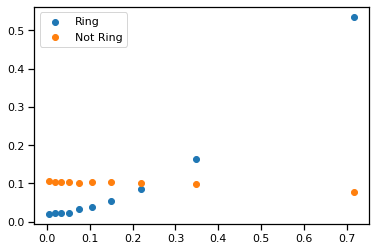

In [175]:
plt.scatter(bin_centers, ring_rates, label='Ring')
plt.scatter(bin_centers, not_ring_rates, label='Not Ring')
plt.legend()

In [176]:
ring_rates

array([0.01892308, 0.02138462, 0.02353846, 0.02369231, 0.03415385,
       0.03923077, 0.05338462, 0.08661538, 0.16323077, 0.53584615])

In [177]:
not_ring_rates

array([0.10521925, 0.10433155, 0.10346524, 0.10358289, 0.10100535,
       0.10255615, 0.10287701, 0.1008984 , 0.09872727, 0.0773369 ])

In [191]:
def empirical_prob_from_histogram(values_to_query, rates, bin_edges):
    bin_edges = bin_edges.copy()
    bin_edges[-1]= bin_edges[-1]+1e-8  # if values_to_query includes exactly the max bin edge
    # rates from 0 to 10, corresponding to frequencies between each (0-11) bin edge 
    assert all(values_to_query <= bin_edges.max())  # no rate above the highest bin edge, bins must cover whole range
    bin_indices = np.digitize(values_to_query, bin_edges)  # should be 10 indices
#     print(bin_indices.min(), bin_indices.max())
    return np.array([rates[bin_index-1] for bin_index in bin_indices])


In [178]:
p_ring = vote_df['is_ring'].mean()
p_ring

0.053334965217185316

In [192]:
def scale_probabity_to_random_sample(scores, ring_rates, not_ring_rates, p_ring, bin_edges):
    p_score_given_ring = empirical_prob_from_histogram(scores, ring_rates, bin_edges)
    p_score_given_not_ring = empirical_prob_from_histogram(scores, not_ring_rates, bin_edges)
    return scale_probability_by_bayes(p_score_given_ring, p_score_given_not_ring, p_ring)
    
def scale_probability_by_bayes(p_score_given_ring, p_score_given_not_ring, p_ring):
    return p_score_given_ring * p_ring / (p_score_given_ring * p_ring + p_score_given_not_ring * (1-p_ring))


In [206]:
p_ring_given_output = scale_probabity_to_random_sample(concentrations_to_mean_prob(all_preds), ring_rates, not_ring_rates, p_ring, bin_edges)

In [207]:
# single_prob_per_galaxy = tfp.distributions.Beta(concentration1=all_preds[:, 0], concentration0=all_preds[:, 1]).sample().numpy()

In [208]:
single_prob_per_galaxy

array([0.89861214, 0.5158321 , 0.00705004, ..., 0.06068999, 0.17402121,
       0.0410161 ], dtype=float32)

In [209]:
single_prob_per_galaxy.min(), single_prob_per_galaxy.max()

(5.590377e-07, 0.99950135)

In [210]:
len(bin_edges)

11

In [211]:
p_ring_given_output = scale_probabity_to_random_sample(
    scores=single_prob_per_galaxy,
    ring_rates=ring_rates,
    not_ring_rates=not_ring_rates,
    p_ring=p_ring,
    bin_edges=bin_edges
)

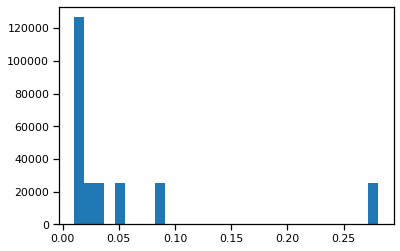

In [212]:
_ = plt.hist(p_ring_given_output, bins=30)

In [213]:
# pd.value_counts(p_ring_given_output)

In [214]:
vote_df['p_ring_given_output'] = p_ring_given_output

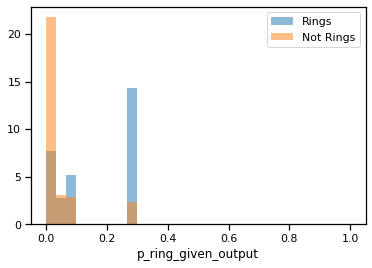

In [215]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

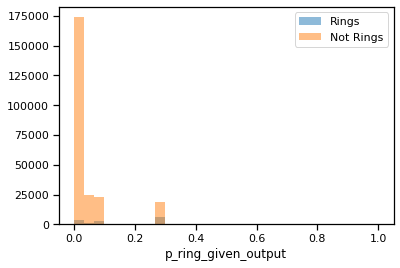

In [216]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

In [217]:
likely_ring = vote_df['p_ring_given_output'] > 0.2

vote_df[likely_ring]['is_ring'].mean()  # actual odds that predicted ring is ring

0.25735499580855054

In [218]:
vote_df[likely_ring]['p_ring_given_output'].mean()  # expected odds that predicted ring is ring

0.2807635548447077

In [158]:
# can use the same scaling to adjust the whole curve?

In [159]:
example_preds = all_preds[:10]

In [172]:
def compare_samples_with_calibration(example_pred):
    raw_samples = tfp.distributions.Beta(concentration1=example_pred[0], concentration0=example_pred[1]).sample(50000).numpy()
    p_ring_given_output = scale_probabity_to_random_sample(
        raw_samples,
        ring_rates,
        not_ring_rates,
        p_ring,
        bin_edges
    )
    plt.hist(raw_samples, bins=20, range=(0, 1), alpha=.5, label='Uncalibrated')
    plt.hist(p_ring_given_output, bins=20, range=(0, 1), alpha=.5, label='Calibrated')
    plt.legend()

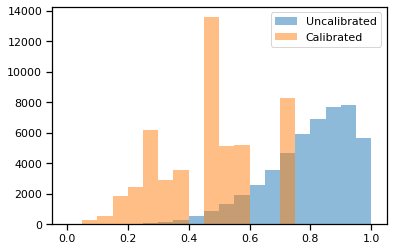

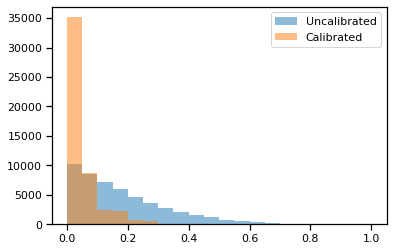

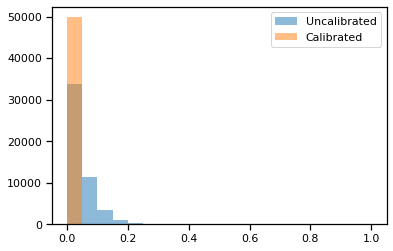

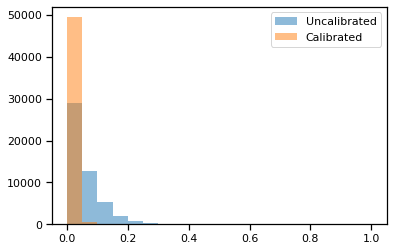

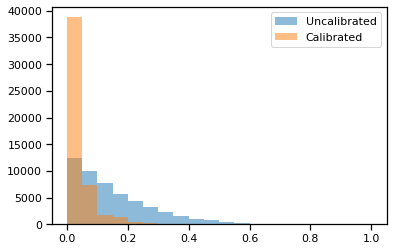

In [173]:
for n in range(5):
    plt.figure()
    compare_samples_with_calibration(example_preds[n])

In [167]:
assert False

AssertionError: 

In [ ]:
def estimate_ring_votes(galaxy):
    if galaxy['is_ring']:
        p = galaxy['rare-features_ring_fraction']
    else:
        p = 0.03
    return 10 * p

In [ ]:
# vote_df['fake_ring_votes'] = vote_df.apply(estimate_ring_votes, axis=1)

In [ ]:

for n, concentration in enumerate(all_preds[:10]):
    plt.plot(x_votes, tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes))
    plt.axvline(estimate_ring_votes(vote_df.iloc[n]), alpha=.2) # probably badly calibrated

In [ ]:
for n, concentration in enumerate(all_preds[:10]):
    uncalibrated_probs = tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes)
    calibrated_probs = scale_probabity_to_random_sample(uncalibrated_probs, ring_rates, not_ring_rates, p_ring)
    plt.plot(x_votes, calibrated_probs)
    plt.axvline(estimate_ring_votes(vote_df.iloc[n]), alpha=.2)

In [ ]:
tfp.distributions.Beta(concentration1=example_preds[:1, 0], concentration0=example_preds[:1, 1]).sample(10).numpy()

In [ ]:
uncalibrated_probs

In [ ]:
calibrated_probs

In [ ]:
# another method:
# simply adjust p_ring_given_output until empirically calibrated i.e. it actually is a ring as much as it says should be a ring

In [ ]:
# with platt scaling - fit logistic regression to output score to predict is_ring

In [ ]:
# Test twice? i.e. then have volunteers verify